# Reimplementation of Stefan's notes in Python (Originally in R)

First, let's put all the libraries together

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

We can do correlation plots like this

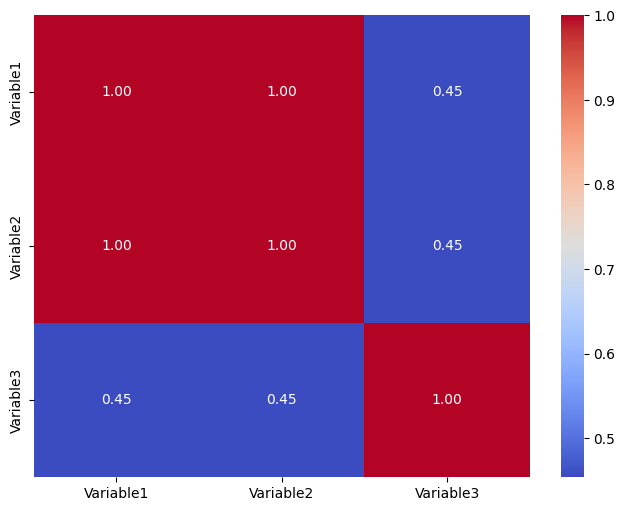

In [2]:
data = pd.DataFrame({
    'Variable1': [1, 2, 3],
    'Variable2': [4, 5, 6],
    'Variable3': [4, -2, 9]
})

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f") #fmt = rounding, cmap = color

# Show the plot
plt.show()

Let's read in our Data and create x and y dataframes.

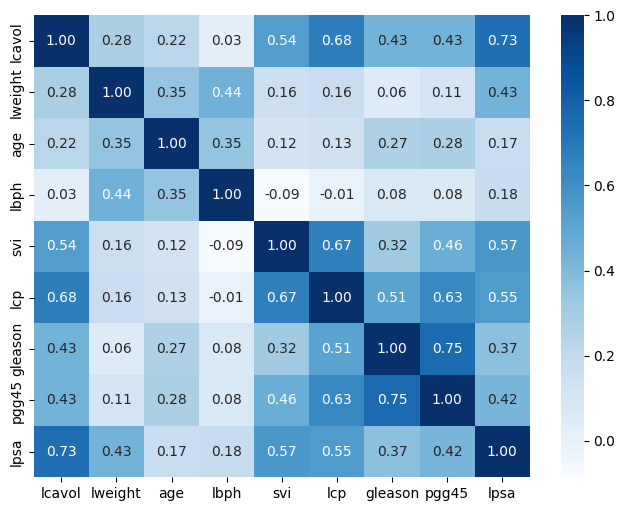

In [3]:
df = pd.read_csv("prostate.csv")
# Correlation Plot
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.show()

Extract x and y

In [4]:
y = df.lpsa.values
del df["lpsa"]
df.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0


Create a standardized dataframe for comparison

In [5]:
df_stand = df.copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_columns = df_stand.select_dtypes(include=[np.number]).columns
df_stand[numeric_columns] = scaler.fit_transform(df_stand[numeric_columns])
df_stand

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
0,-1.645861,-2.016634,-1.872101,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957
1,-1.999313,-0.725759,-0.791989,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957
2,-1.587021,-2.200154,1.368234,-1.030029,-0.525657,-0.867655,0.344407,-0.156155
3,-2.178174,-0.812191,-0.791989,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957
4,-0.510513,-0.461218,-0.251933,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957
...,...,...,...,...,...,...,...,...
92,1.262444,0.580608,0.558151,-1.030029,1.902379,1.079149,0.344407,1.269449
93,2.107397,0.628738,-2.682185,-1.030029,1.902379,1.688267,0.344407,0.556647
94,1.328267,-0.546127,-1.602073,-1.030029,1.902379,1.900197,0.344407,-0.512556
95,1.307045,0.340141,0.558151,1.010033,1.902379,1.249088,0.344407,1.982251


Test whether data has actually been standardized:

In [6]:
df_stand["lcavol"].mean().round(2)
df_stand["lcavol"].std().round(2)

1.01

Plot a full LM using all features

In [7]:
model = LinearRegression().fit(df_stand, y)
r_sq = model.score(df_stand, y)
print("Coefficient of Determination: ", r_sq)
print("Intercept:", model.intercept_.round(2))
print("Coefficients: ", model.coef_.round(2))

Coefficient of Determination:  0.6633895652370272
Intercept: 2.48
Coefficients:  [ 0.66  0.27 -0.16  0.14  0.31 -0.15  0.04  0.13]


To get the full output similar to what we would get in R, we have to use `statsmodels`

In [8]:
import statsmodels.api as sm
x_with_intercept = sm.add_constant(df_stand) # Needed in statsmodels, idk why
stats_model = sm.OLS(y, x_with_intercept).fit()
print(stats_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     21.68
Date:                Mon, 05 Feb 2024   Prob (F-statistic):           7.65e-18
Time:                        18:50:27   Log-Likelihood:                -98.248
No. Observations:                  97   AIC:                             214.5
Df Residuals:                      88   BIC:                             237.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4784      0.071     34.895      0.0

We now apply the Ridge penalty to the data. First, we need to find the optimal alpha value.

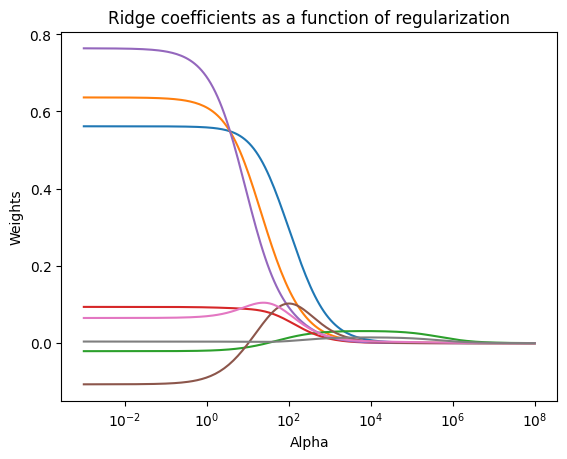

In [9]:
n_alphas = 200 #number of alphas
alphas = np.logspace(-3, 8, n_alphas)

coefs = []

for a in alphas:
    ridge = Ridge(alpha = a, fit_intercept=False)
    ridge.fit(df, y)
    coefs.append(ridge.coef_)

# Display results
ax = plt.gca() #Get current axis
ax.plot(alphas, coefs)
ax.set_xscale("log")
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("Alpha")
plt.ylabel("Weights")
plt.title("Ridge coefficients as a function of regularization")
plt.axis("tight")
plt.show()

CV

Optimal alpha: 1.6070528182616401


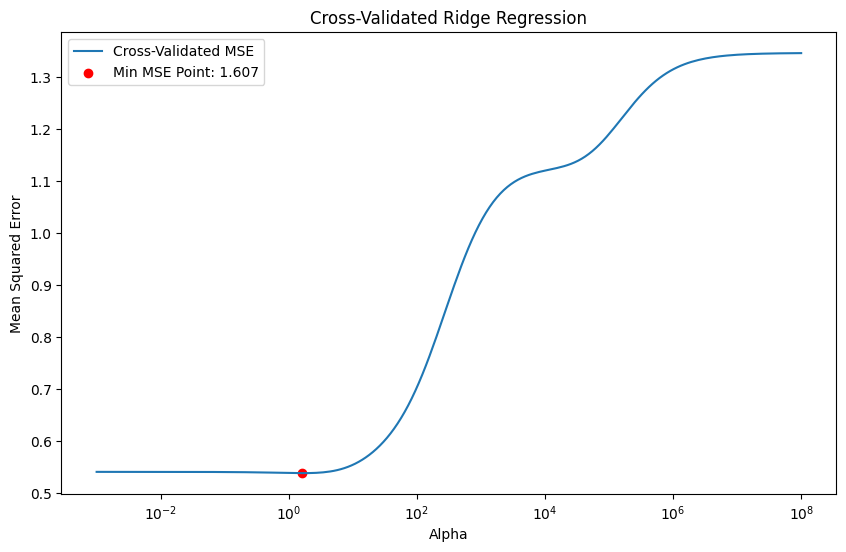

[ 0.56284816  0.56263652 -0.01989118  0.09891682  0.64677681 -0.07815432
  0.03461782  0.00465319]


In [28]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(df, y)
print("Optimal alpha:", ridge_cv.alpha_)

# Create figure to do visualize this

plt.figure(figsize=(10, 6))
cv_mse_mean = np.mean(ridge_cv.cv_values_, axis=0)
plt.plot(alphas, cv_mse_mean, label='Cross-Validated MSE')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Cross-Validated Ridge Regression')
min_mse_alpha = ridge_cv.alpha_
min_mse_value = np.min(cv_mse_mean)
plt.scatter(min_mse_alpha, min_mse_value, color='red', label='Min MSE Point: %.3f' % min_mse_alpha )
plt.legend()
plt.show()

print(ridge_cv.coef_)